In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [15]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    # Dense(117,activation='softmax')
    Dense(6,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [18]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 14303 images belonging to 6 classes.
Found 1818 images belonging to 6 classes.


In [19]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Poland: 0.16344253165751133
Sweden: 0.16492016399044093
Finland: 0.1667707379156762
Mexico: 0.16746677314002842
Denmark: 0.1683097624496165
Norway: 0.16909003084672664


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=2000,
    validation_data=validation_generator,
    # validation_steps=200,
    batch_size=64,
    epochs=3,
    # class_weight = class_weights,
    # verbose=1
    callbacks=[early_stopping]
)

Epoch 1/3
447/447 [==============================] - 327s 732ms/step - loss: 1.5516 - categorical_accuracy: 0.3776 - val_loss: 1.4337 - val_categorical_accuracy: 0.4406
Epoch 2/3
447/447 [==============================] - 177s 396ms/step - loss: 1.3107 - categorical_accuracy: 0.4933 - val_loss: 1.4015 - val_categorical_accuracy: 0.4395
Epoch 3/3
447/447 [==============================] - 195s 436ms/step - loss: 1.1531 - categorical_accuracy: 0.5607 - val_loss: 1.1178 - val_categorical_accuracy: 0.5710


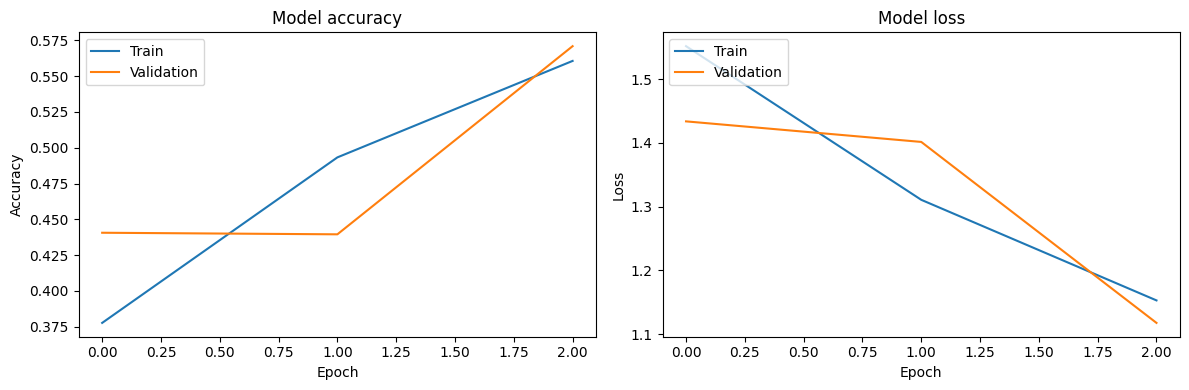

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [23]:
model.save('my_model.h5')


c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\test'
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

class_names = test_generator.class_indices.keys()

Found 1861 images belonging to 6 classes.


59/59 [==============================] - 33s 553ms/step
Classification Report: 
              precision    recall  f1-score   support

     Denmark       0.59      0.55      0.57       348
     Finland       0.53      0.65      0.58       288
      Mexico       0.67      0.71      0.69       310
      Norway       0.65      0.58      0.61       317
      Poland       0.51      0.55      0.53       284
      Sweden       0.52      0.43      0.47       314

    accuracy                           0.58      1861
   macro avg       0.58      0.58      0.58      1861
weighted avg       0.58      0.58      0.58      1861



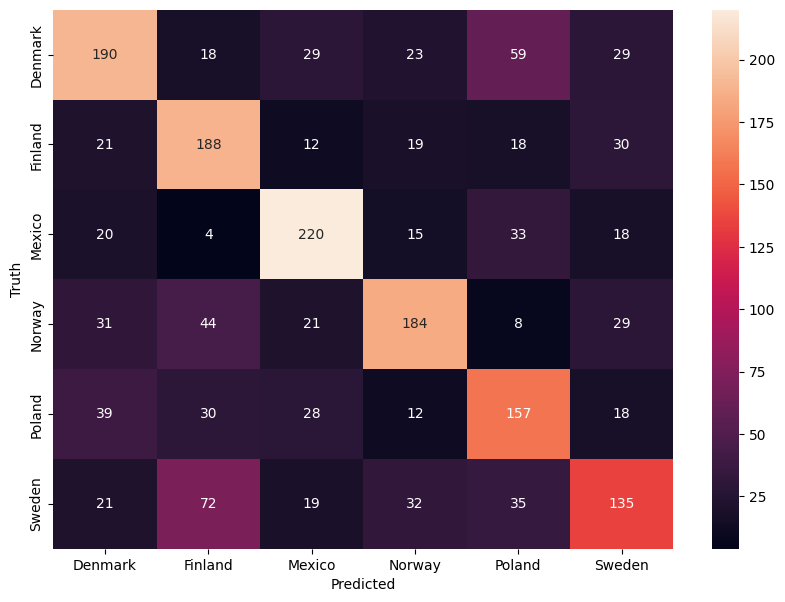

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes

# Predict the values from the validation dataset
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# classification report
print('Classification Report: ')
print(classification_report(y_true, y_pred_classes, target_names=class_names))


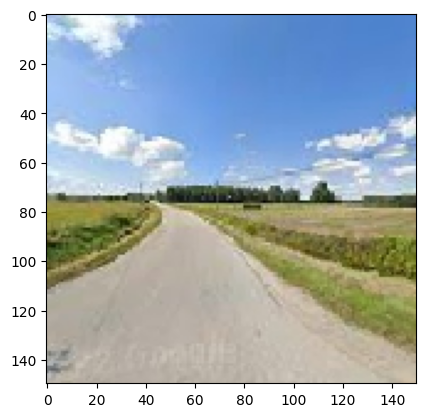

1/1 [==============================] - 0s 65ms/step
Country: ['Poland'], Probability: 0.5320161581039429
Country: ['Denmark'], Probability: 0.23033258318901062
Country: ['Mexico'], Probability: 0.08610188215970993
Country: ['Sweden'], Probability: 0.07157216221094131
Country: ['Finland'], Probability: 0.047719668596982956
Country: ['Norway'], Probability: 0.032257627695798874


In [29]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Poland\_t3q0ct2UHEnJ0t3jR2SkQNum0.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
